In [94]:
%matplotlib inline
import sklearn
import codecs, os, sys, json, string
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
from sklearn import preprocessing
# import sympy
# from sympy import symbols, integrate
from sympy import *

In [460]:
def join_path(d, file):
    return os.path.join(d, file)

def create_new_empty_data_dict(l):
    d = {}
    for i in l:
        d[i] = []
    return d

In [245]:
data_path = "..\\data\\extracted\\"
bhot100 = pd.read_csv(join_path(data_path, 'hot-100.csv'))
bhot100['title'] = bhot100.apply(lambda row: row['title'].lower().strip(), axis=1)
bhot100['artist_name'] = bhot100.apply(lambda row: row['artist_name'].lower().strip(), axis=1)
grammy = pd.read_csv(join_path(data_path, 'grammy.csv'), 
                     dtype={'award_for': 'str',
                            'name': 'str'
                        })
grammy['award_for'] = grammy.apply(lambda row: str(row['award_for']).lower().strip(), axis=1)
grammy['name'] = grammy.apply(lambda row: str(row['name']).lower().strip(), axis=1)
grammy = grammy[grammy['award_type']=='Work']
grammy = grammy[grammy.apply(lambda row: 'album' not in str(row['category']).lower(), axis=1)]
ama = pd.read_csv(join_path(data_path, 'ama.csv'), 
                    dtype={'award_for': 'str',
                            'name': 'str'
                    })
ama['award_for'] = ama.apply(lambda row: str(row['award_for']).lower().strip(), axis=1)
ama['name'] = ama.apply(lambda row: str(row['name']).lower().strip(), axis=1)

# msd = pd.read_csv(join_path(data_path, 'MSDSet.csv'))
# msd['artist_name'] = msd.apply(lambda row: str(row['artist_name']).lower().strip(), axis=1)
# msd['title'] = msd.apply(lambda row: str(row['title']).lower().strip(), axis=1)


In [246]:
grammy

,Unnamed: 0,year,name,award_for,category,award_type
3,3,1958,ella fitzgerald,ella fitzgerald sings the irving berlin song book,"Best Vocal Performance, Female",Work
8,8,1958,ella fitzgerald,ella fitzgerald sings the duke ellington song ...,"Best Jazz Performance, Individual",Work
13,13,1958,henry mancini,the music from peter gunn,Best Arrangement,Work
31,31,1959,ella fitzgerald,but not for me,"Best Vocal Performance, Female",Work
32,32,1959,frank sinatra,come dance with me,"Best Vocal Performance, Male",Work
33,33,1959,duke ellington,anatomy of a murder,Best Performance By A Dance Band,Work
34,34,1959,andré previn,like young,Best Performance By An Orchestra,Work
36,36,1959,ella fitzgerald,ella swings lightly,Best Jazz Performance - Soloist,Work
44,44,1959,duke ellington,anatomy of a murder,Best Musical Composition First Recorded And Re...,Work
62,62,1961,henry mancini,moon river,Record Of The Year,Work


In [67]:
spotify = pd.read_csv(join_path(data_path, 'spotify2.csv'))
spotify['title'] = spotify.apply(lambda row: str(row['title']).lower().strip(), axis=1)
spotify['artist_name'] = spotify.apply(lambda row:str(row['artist_name']).lower().strip(), axis=1)

In [37]:
titles = bhot100.title
merge_song_bhot100 = bhot100[['title', 'artist_name', 'current_rank']].groupby(['title', 'artist_name']).sum()
count_onchart_bhot100 = bhot100[['title', 'artist_name', 'current_rank']].groupby(['title', 'artist_name'])\
                        .count().rename(columns={"current_rank": "onchart_count"})
bhot100_song_num = len(merge_song_bhot100)

# count_onchart_bhot100 = count_onchart_bhot100.sort_values('onchart_count', ascending=False)
# count_onchart_bhot100
avr_bhot100_ranks = merge_song_bhot100.current_rank / count_onchart_bhot100.onchart_count
avr_bhot100_ranks.sort_values()
# avr_bhot100_ranks['Radioactive']


title                                            artist_name                                
zeze                                             kodak black featuring travis scott & offset      4.666667
in my feelings                                   drake                                            5.722222
sicko mode                                       travis scott                                     6.307692
girls like you                                   maroon 5 featuring cardi b                       6.478261
get back                                         the beatles with billy preston                   6.833333
mrs. brown you've got a lovely daughter          herman's hermits                                 7.000000
i want to hold your hand                         the beatles                                      7.533333
hey jude                                         the beatles                                      7.842105
i like it                                        ca

In [38]:
overall_avr_bhot_rank = np.mean(avr_bhot100_ranks)
print (overall_avr_bhot_rank)
blamda = 1/overall_avr_bhot_rank
print (blamda)

61.82629783506455
0.016174347082332556


In [39]:
def rank_prob(rank):
    x = symbols('x')
    return integrate(blamda * exp(blamda*(x-100)), (x, rank-1, rank))
#     return blamda*np.exp(blamda*(rank-100))

In [40]:
rank_prob(1)/rank_prob(2)

0.983955755284751

In [41]:
rank_prob(1)/rank_prob(10)

0.864530128451833

In [42]:
rank_prob(1)/rank_prob(25)

0.678287303057853

In [43]:
rank_prob(1)/rank_prob(50)

0.452692131013324

In [44]:
rank_prob(1)/rank_prob(100)

0.201642215756864

In [45]:
rank_prob(1)/rank_prob(101)

0.198407018702331

In [46]:
rank_prob(1)

0.00323519705453182

In [49]:
rank_prob_table_bhot100 = [float(rank_prob(i)) for i in range(1, 101)]
rankprobsum = np.sum(rank_prob_table_bhot100)
rankprobsum

0.8015929812976694

In [50]:
out_chart_prob = 1-rankprobsum
rank_prob_table_bhot100.append(out_chart_prob)
rank_prob_table_bhot100

[0.0032351970545318187,
 0.003287949724523509,
 0.0033415625721626985,
 0.003396049623385494,
 0.003451425132833086,
 0.003507703587580846,
 0.0035648997109283265,
 0.003623028466251288,
 0.00368210506091593,
 0.003742144950257875,
 0.0038031638416251845,
 0.0038651776984877095,
 0.003928202744613446,
 0.003992255468312944,
 0.004057352626752664,
 0.004123511250339329,
 0.004190748647174669,
 0.004259082407584547,
 0.0043285304087195,
 0.004399110819232832,
 0.004470842104033257,
 0.004543743029115643,
 0.0046178326664707,
 0.004693130399074097,
 0.004769655925957794,
 0.004847429267363312,
 0.004926470769979485,
 0.005006801112265313,
 0.00508844130985997,
 0.0051714127210806815,
 0.005255737052510201,
 0.005341436364676155,
 0.005428533077821596,
 0.00551704997777136,
 0.005607010221892361,
 0.005698437345152629,
 0.005791355266277831,
 0.005885788294009209,
 0.005981761133462715,
 0.006079298892592733,
 0.006178427088760208,
 0.006279171655408811,
 0.006381558948849009,
 0.006485615

In [ ]:
# f_score_table_bhot100 = -np.log(rank_prob_table_bhot100)
# f_score_table_bhot100
# f_norm_score_table_bhot100 = preprocessing.MinMaxScaler()\
#         .fit_transform(np.array(f_score_table_bhot100).reshape(-1, 1))
# f_norm_score_table_bhot100 = f_norm_score_table_bhot100.reshape(-1).tolist()
# f_norm_score_table_bhot100

In [51]:
score_table_bhot100 = [1/i for i in rank_prob_table_bhot100]
score_table_bhot100

[309.10018250641457,
 304.14090353675357,
 299.26119245248435,
 294.4597726469934,
 289.73538799584355,
 285.086802528166,
 280.51280010331413,
 276.01218409268813,
 271.5837770667109,
 267.22642048675556,
 262.93897440207985,
 258.7203171515918,
 254.56934507040185,
 250.48497220108567,
 246.46613000959653,
 242.5117671056939,
 238.62084896792436,
 234.79235767291246,
 231.0252916291347,
 227.31866531482186,
 223.6715090201632,
 220.0828685936123,
 216.55180519225618,
 213.07739503621912,
 209.65872916696608,
 206.29491320951965,
 202.98506713847084,
 199.72832504775744,
 196.52383492412125,
 193.37075842421407,
 190.26827065528104,
 187.2155599593348,
 184.21182770084323,
 181.2562880577629,
 178.34816781598462,
 175.48670616702475,
 172.67115450900513,
 169.90077625079383,
 167.17484661931346,
 164.49265246991575,
 161.8534920998258,
 159.25667506455423,
 156.70152199727968,
 154.18736443110066,
 151.71354462416502,
 149.27941538759438,
 146.88433991616418,
 144.52769162170975,
 142

In [52]:
norm_score_table_bhot100 = preprocessing.MinMaxScaler((1, 100))\
        .fit_transform(np.array(score_table_bhot100).reshape(-1, 1))
norm_score_table_bhot100 = (norm_score_table_bhot100).reshape(-1).tolist()
norm_score_table_bhot100

[99.99999999999999,
 98.38529054703532,
 96.79648788767526,
 95.23317636698701,
 93.69494699890325,
 92.1813973592293,
 90.69213148036376,
 89.22675974770266,
 87.7848987977208,
 86.36617141766527,
 84.97020644687932,
 83.59663867969914,
 82.24510876990905,
 80.91526313673064,
 79.60675387232557,
 78.31923865076892,
 77.05238063850477,
 75.80584840620506,
 74.579315842088,
 73.37246206658087,
 72.1849713483833,
 71.01653302186605,
 69.86684140579288,
 68.73559572335593,
 67.62250002348085,
 66.52726310340628,
 65.44959843249835,
 64.38922407729197,
 63.3458626277301,
 62.31924112459073,
 61.30909098807889,
 60.31514794755507,
 59.33715197240775,
 58.37484720401522,
 57.42798188881836,
 56.496308312450225,
 55.579582734936416,
 54.677565326924515,
 53.79002010694495,
 52.916714879670145,
 52.05742117517317,
 51.21191418915273,
 50.37997272412523,
 49.56137913155115,
 48.755919254898316,
 47.96338237361516,
 47.183561148001296,
 46.416251564965535,
 45.66125288465183,
 44.91836758792438,

In [247]:
grammy_num = len(grammy)
grammy['cnt'] = grammy['year']
artist_grammy_count = grammy[['name', 'cnt']].groupby(['name']).count()
artist_grammy_count

,cnt
name,
"""weird al"" yankovic",2
a great big world,1
adele,8
adele adkins,2
aerosmith,4
alabama shakes,3
alan menken,6
alicia keys,10
alison krauss,14


In [248]:
# both grammy and billboard started from 1958
grammy_score = bhot100_song_num/grammy_num*100
grammy_score

3135.472972972973

In [55]:
#ama started from 1974
ama['cnt'] = ama['year']
ama_num = len(ama)
ama_score = bhot100_song_num/ama_num*100*(2018-1974)/(2018-1958)
ama_score

1982.3495145631068

In [57]:
def get_year_billboard_rank_score(rs):
    s = 0
    for r in rs:
        s += norm_score_table_bhot100[int(r-1)]
    s += (52 - len(rs))*norm_score_table_bhot100[100]
    return s

In [256]:
def get_scores(br, gr, ar, release_year):
    # order: from the year to now (which is 2018-1958)
    b_onchart_ranks = [[] for i in range(61)]
    for i in range(len(br)):
        on_chart_date_year = int(br.iloc[i]['chart_date'].split('-')[0])
        if on_chart_date_year >= 1958 and on_chart_date_year <= 2018:
            b_onchart_ranks[on_chart_date_year-1958].append(br.iloc[i]['current_rank'])
    
    grammy_wins = [0 for i in range(61)]
    for i in range(len(gr)):
        grammy_win_year = int(gr.iloc[i]['year'])
        grammy_wins[grammy_win_year - 1958] = 1
    
    
    ama_wins = [0 for i in range(61)]
    for i in range(len(ar)):
        ama_win_year = int(ar.iloc[i]['year'])
        ama_wins[ama_win_year - 1958] = 1
    
    final_scores = []
    for i in range(61):
        bill_year_score = get_year_billboard_rank_score(b_onchart_ranks[i])
        grammy_year_score = grammy_wins[i]*grammy_score/10
        ama_year_score = ama_wins[i]*ama_score/10
        final_scores.append(bill_year_score+grammy_year_score+ama_year_score)
    final_scores.reverse()
    return final_scores
    

In [257]:
def generate_feature():
    # from 01/04/1958 - 11/10/2018 22228 days which are 3175 weeks, 61 years
    mbhotd = merge_song_bhot100.reset_index()
    titles = mbhotd['title'].tolist()
    artists = mbhotd['artist_name'].tolist()
    feature_d = {'title':[],
                'artist_name':[],
                 'release_date':[],
                 'peak_rank':[], 'weeks_on_chart':[], 'onchart_dates':[], 'bill_ranks':[],
                'grammy':[], 'ama':[],
                'spotify_popularity_2018':[]}
    for i in range(0, 61):
        feature_d['y_'+str(i)] = []
    
    for title, name in zip(titles, artists):
        
        spotify_records = spotify[(spotify['title']==title) & (spotify['artist_name']==name)]
        if len(spotify_records) == 0:
            continue
            
        sr_real = spotify_records.iloc[np.argmax(spotify_records['spotify_score'].tolist())]
        
        datestr = str(sr_real['release_date'])

        if len(datestr) <= 4:
            release_date = datestr + '-1-1'
        elif len(datestr) == 6 or len(datestr) == 7:
            release_date = datestr + '-1'
        else:
            release_date = datestr
        release_year = int(release_date.split('-')[0])
        if release_year < 1958:
            continue
        
        bill_records = bhot100[(bhot100['title']==title) & (bhot100['artist_name']==name)]
        grammy_records = grammy[(grammy['award_for']==title) & (grammy['name']==name)]
        ama_records = ama[(ama['award_for']==title) & (ama['name']==name)]
        popularity_2018 = sr_real['spotify_score']
        
        scores = get_scores(bill_records, grammy_records, ama_records, release_year)
        
        # put in feature dictionary
        feature_d['release_date'].append(release_date)
        feature_d['title'].append(title)
        feature_d['artist_name'].append(name)
        feature_d['spotify_popularity_2018'].append(popularity_2018)
        feature_d['peak_rank'].append(np.min(bill_records['current_rank'].tolist()))
        feature_d['weeks_on_chart'].append(len(bill_records))
        feature_d['onchart_dates'].append('|'.join(bill_records['chart_date'].tolist()))
        feature_d['bill_ranks'].append('|'.join([str(i) for i in bill_records['current_rank'].tolist()]))
        feature_d['grammy'].append(len(grammy_records))
        feature_d['ama'].append(len(ama_records))
        for i in range(0, 61):
            feature_d['y_'+str(i)].append(scores[i])
    feature_df = pd.DataFrame.from_dict(feature_d)
    feature_df.to_csv(join_path(data_path, 'features_gcorrected.csv'))
        

In [259]:
import time
st = time.time()
generate_feature()
time.time()-st

2523.1250519752502

In [265]:
feature_gap_df = pd.read_csv(join_path(data_path, 'features_gcorrected.csv'))
FEATURES = ['y_'+str(i) for i in range(0, 61)]
print (len(feature_df))

25281


In [261]:
from sklearn import linear_model
lr = linear_model.LinearRegression()
lr.fit(feature_df[FEATURES], feature_df['spotify_popularity_2018'])
lr_coefs = lr.coef_
print ('Coefficients of Linear Regression: \n', lr_coefs)

Coefficients of Linear Regression: 
 [ 0.03938401  0.02381129  0.02112635  0.02140163  0.02043661  0.01855985
  0.01900309  0.0178596   0.01111922  0.01790573  0.01591454  0.0172508
  0.01785872  0.01663856  0.01554504  0.01624033  0.01555681  0.0124233
  0.01343951  0.01717     0.01064903  0.00926179  0.01195305  0.01200564
  0.01253384  0.01451824  0.01150009  0.00885965  0.01075653  0.01265381
  0.01480189  0.01484248  0.01441711  0.01433514  0.01586545  0.0139156
  0.01056036  0.01226629  0.00993778  0.01365621  0.01352583  0.01108386
  0.01203462  0.00868574  0.00905071  0.00884982  0.01165805  0.0087031
  0.00485074  0.00393114  0.00452234  0.00430148  0.00313177  0.00236244
  0.00119362 -0.00367646 -0.00628594 -0.00708189 -0.0057379  -0.00492119
 -0.00678931]


<BarContainer object of 61 artists>

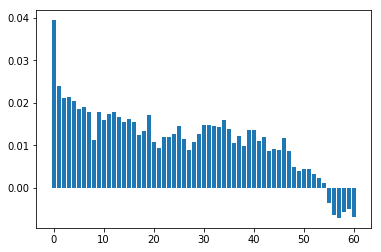

In [262]:
plt.bar(range(len(lr_coefs)), lr_coefs)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


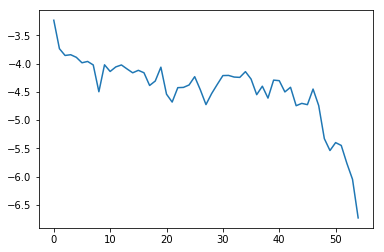

In [263]:
plt.plot(range(len(lr_coefs)), np.log(lr_coefs))

In [264]:
lr_popularity_pred = lr.predict(feature_df[FEATURES])
lr_popularity_truth = feature_df['spotify_popularity_2018']
lr_rmse = np.sqrt(sklearn.metrics.mean_squared_error(lr_popularity_pred, lr_popularity_truth))
print ("LR RMSE: {}".format(lr_rmse))

LR RMSE: 19.12006533860545


In [97]:
lr_popularity_truth

0        65
1        18
2        51
3        53
4        63
5        65
6        70
7        20
8        35
9         3
10       12
11       34
12       34
13       41
14       43
15       49
16        6
17       63
18       14
19       21
20        4
21        7
22        5
23       16
24       22
25        6
26        1
27       41
28        6
29       23
         ..
25296    13
25297    55
25298    60
25299     9
25300    73
25301    40
25302    63
25303    11
25304    80
25305    66
25306    59
25307    69
25308    63
25309    42
25310    35
25311    22
25312    76
25313    57
25314     5
25315    95
25316    15
25317    33
25318     4
25319    20
25320    75
25321    51
25322    46
25323    30
25324    25
25325    15
Name: spotify_popularity_2018, Length: 25326, dtype: int64

In [159]:
def analysis_rank(df, analysis_range=(1, 100)):
    # rank within 10 100 500
    l_r = analysis_range[0]
    r_r = analysis_range[1]
    tp = []
    fp = []
    tn = []
    fn = []
    for i in range(len(df)):
        r = df.iloc[i]
#         print (r)
        if r['pred'] >= l_r and r['pred'] <= r_r:
            if r['truth'] >= l_r and r['truth'] <= r_r:
                tp.append(i)
            else:
                fp.append(i)
        elif r['pred'] < l_r or r['pred'] > r_r:
            if r['truth'] >= l_r and r['truth'] <= r_r:
                fn.append(i)
            else:
                tn.append(i)
    return tp, fp, tn, fn, len(tp)/(len(tp)+len(fp)), len(tp)/(len(tp)+len(fn))

In [269]:
def analysis_model(popularity_pred, mdname=''):
#     popularity_pred = md.predict(feature_gap_df[FEATURES])
    popularity_truth = feature_gap_df['spotify_popularity_2018']
#     release_date = feature_df['release_date']
    rmse = np.sqrt(sklearn.metrics.mean_squared_error(popularity_pred, popularity_truth))
    print ("RMSE: {}".format(rmse))
    
    
    popularity_pred = pd.Series(popularity_pred)
#     print (popularity_pred)
    
    popularity_pred = popularity_pred.sort_values(ascending=False)
    popularity_truth = popularity_truth.sort_values(ascending=False)
    
#     print(popularity_pred.index, popularity_truth.index)
    
#     if not os.path.exists(join_path(data_path, mdname+'_pred_rank.csv')):
    popularity_pred_index = popularity_pred.index.tolist()
    popularity_truth_index = popularity_truth.index.tolist()

    ranks_d = {'pred':[], 'truth':[], 'title':[], 'artist_name':[], 'release_date':[], 
               'error':[], 'spotify_popularity_2018':[], 'predicted_popularity':[],
                'peak_rank':[], 'weeks_on_chart':[], 'onchart_dates':[], 'bill_ranks':[],
                'grammy':[], 'ama':[],
               'index':[]}
    for rank_pred, index in enumerate(popularity_pred_index):
        rank_truth = popularity_truth_index.index(index)+1
        title = feature_gap_df['title'].iloc[index]
        artist_name = feature_gap_df['artist_name'].iloc[index]
        release_date = feature_gap_df['release_date'].iloc[index]     
                
        ranks_d['pred'].append(rank_pred+1)
        ranks_d['truth'].append(rank_truth)
        ranks_d['title'].append(title)
        ranks_d['artist_name'].append(artist_name)
        ranks_d['release_date'].append(release_date)
        ranks_d['error'].append(abs(rank_truth-rank_pred))
        ranks_d['spotify_popularity_2018'].append(feature_gap_df['spotify_popularity_2018'].iloc[index])
        ranks_d['predicted_popularity'].append(popularity_pred.iloc[rank_pred])
        ranks_d['peak_rank'].append(feature_gap_df['peak_rank'].iloc[index])
        ranks_d['weeks_on_chart'].append(feature_gap_df['weeks_on_chart'].iloc[index])
        ranks_d['onchart_dates'].append(feature_gap_df['onchart_dates'].iloc[index])
        ranks_d['bill_ranks'].append(feature_gap_df['bill_ranks'].iloc[index])
        ranks_d['grammy'].append(feature_gap_df['grammy'].iloc[index])
        ranks_d['ama'].append(feature_gap_df['ama'].iloc[index])
        ranks_d['index'].append(index)
    ranks_df = pd.DataFrame.from_dict(ranks_d)

    ranks_df.to_csv(join_path(data_path, mdname+'_pred_rank_stat_correct.csv'))
#     else:
#         ranks_df = pd.read_csv(join_path(data_path, mdname+'_pred_rank.csv'))
    
    rank_rmse = np.sqrt(np.sum((np.array(ranks_df['pred']) - np.array(ranks_df['truth']))**2)/len(ranks_df))
    print ('{} Rank RMSE: {}'.format(mdname, rank_rmse))
    
    
    analysis_ranges = [(1, 10), (1, 100), (1, 200), (1, 500), (1, 1000)]
    for r in analysis_ranges:
        tp, fp, tn, fn, precision, recall = analysis_rank(ranks_df, r)
#         print (len(tp), len(fp), len(tn), len(fn))
#         print (fp, fn)
        print ("Top {} Percision: {}, Recall: {}".format(r[1], precision, recall))
    
    another_mh100 = bhot100.groupby(['title', 'artist_name'])['on_chart_weeks'].max().reset_index().sort_values(['on_chart_weeks'], ascending=False)

In [486]:
analysis_model(lr_pred, 'LR_gap')

TypeError: Expected sequence or array-like, got estimator LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [489]:
feature_gap_df = pd.read_csv(join_path(data_path, 'features_gcorrected.csv'))
FEATURES = ['y_'+str(i) for i in range(0, 61)]
# print (len(feature_df))
lr_gap = linear_model.LinearRegression()
lr_gap.fit(feature_gap_df[FEATURES], feature_gap_df['spotify_popularity_2018'])
lr_gap_coefs = lr_gap.coef_
print ('Coefficients of Linear Regression: \n', lr_gap_coefs)

Coefficients of Linear Regression: 
 [ 0.03938401  0.02381129  0.02112635  0.02140163  0.02043661  0.01855985
  0.01900309  0.0178596   0.01111922  0.01790573  0.01591454  0.0172508
  0.01785872  0.01663856  0.01554504  0.01624033  0.01555681  0.0124233
  0.01343951  0.01717     0.01064903  0.00926179  0.01195305  0.01200564
  0.01253384  0.01451824  0.01150009  0.00885965  0.01075653  0.01265381
  0.01480189  0.01484248  0.01441711  0.01433514  0.01586545  0.0139156
  0.01056036  0.01226629  0.00993778  0.01365621  0.01352583  0.01108386
  0.01203462  0.00868574  0.00905071  0.00884982  0.01165805  0.0087031
  0.00485074  0.00393114  0.00452234  0.00430148  0.00313177  0.00236244
  0.00119362 -0.00367646 -0.00628594 -0.00708189 -0.0057379  -0.00492119
 -0.00678931]


Text(0, 0.5, 'Coefficient')

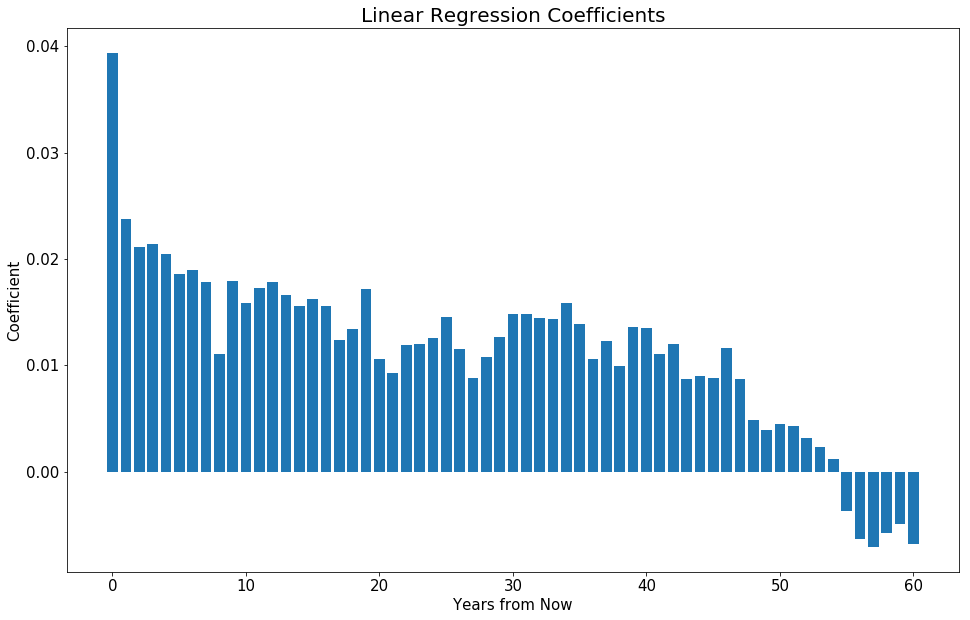

In [490]:
fig, ax = plt.subplots(figsize=(16,10))
ax.bar(range(len(lr_gap_coefs)), lr_gap_coefs)
ax.tick_params(labelsize=15)
ax.set_title('Linear Regression Coefficients', fontsize=20)
ax.set_xlabel('Years from Now', fontsize=15)
ax.set_ylabel('Coefficient', fontsize=15)

Text(0, 0.5, 'Log(coefficient)')

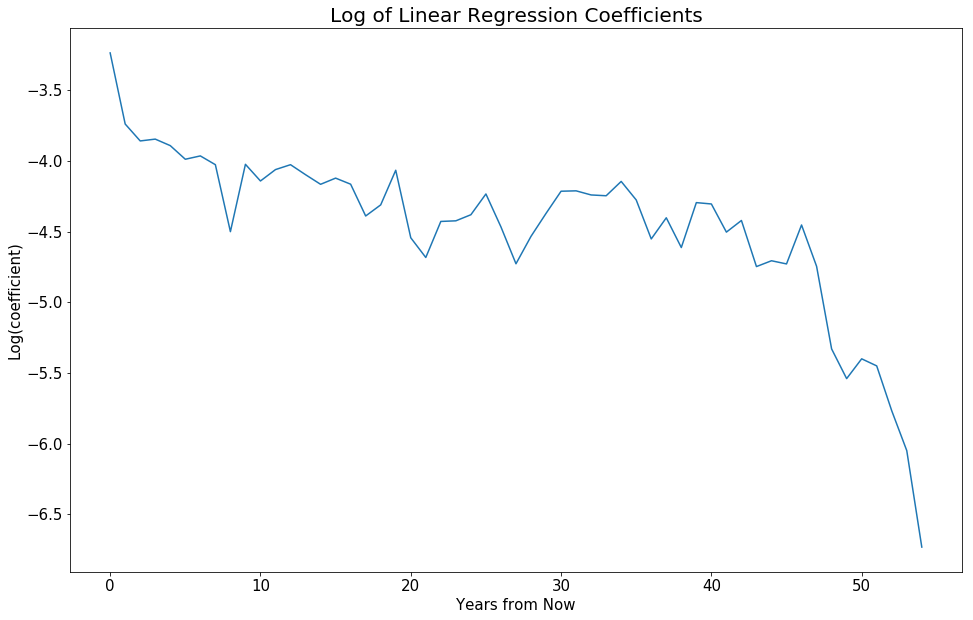

In [493]:
fig, ax = plt.subplots(figsize=(16,10))
ax.plot(range(len(lr_gap_coefs)), np.log(lr_gap_coefs))
ax.tick_params(labelsize=15)
ax.set_title('Log of Linear Regression Coefficients', fontsize=20)
ax.set_xlabel('Years from Now', fontsize=15)
ax.set_ylabel('Log(coefficient)', fontsize=15)

In [494]:
lr_gap_popularity_pred = lr_gap.predict(feature_gap_df[FEATURES])
lr_gap_popularity_truth = feature_gap_df['spotify_popularity_2018']
lr_gap_rmse = np.sqrt(sklearn.metrics.mean_squared_error(lr_gap_popularity_pred, lr_gap_popularity_truth))
print ("LR RMSE: {}".format(lr_gap_rmse))

LR RMSE: 19.12006533860545


In [495]:
analysis_model(lr_gap_popularity_pred, 'LR_gap')

RMSE: 19.12006533860545
LR_gap Rank RMSE: 7116.943272462667
Top 10 Percision: 0.0, Recall: 0.0
Top 100 Percision: 0.27, Recall: 0.27
Top 200 Percision: 0.31, Recall: 0.31
Top 500 Percision: 0.316, Recall: 0.316
Top 1000 Percision: 0.35, Recall: 0.35


In [194]:
print (lr_gap_coefs - lr_coefs)

[-6.93889390e-18  1.38777878e-17  1.04083409e-16  3.46944695e-18
 -6.93889390e-18 -1.11022302e-16  6.93889390e-18  6.93889390e-17
  1.90819582e-17  5.55111512e-17  3.46944695e-17 -3.46944695e-18
  6.93889390e-18  1.63064007e-16 -1.04083409e-17  3.12250226e-17
  4.51028104e-17  5.20417043e-18  2.08166817e-17  6.93889390e-18
  0.00000000e+00  1.73472348e-17  4.51028104e-17  4.16333634e-17
  6.07153217e-17 -7.11236625e-17  5.03069808e-17  1.73472348e-18
  1.73472348e-17  8.15320034e-17  5.20417043e-17  4.51028104e-17
  1.73472348e-18  1.73472348e-17  2.77555756e-17  2.08166817e-17
  5.20417043e-18  2.77555756e-17  5.20417043e-18  1.90819582e-17
  3.98986399e-17  3.98986399e-17  3.12250226e-17  3.29597460e-17
  5.20417043e-17 -5.20417043e-18  1.56125113e-17 -3.46944695e-18
  1.47451495e-17  1.38777878e-17  2.25514052e-17  6.07153217e-18
  1.56125113e-17  2.77555756e-17  2.55871713e-17  1.90819582e-17
  1.38777878e-17 -5.20417043e-18 -6.93889390e-18  3.12250226e-17
 -3.81639165e-17]


In [267]:
import lightgbm as lgbm
def run_lgb(train_X, train_y, val_X, val_y, test_X, mode='train'):
    params = {
        "objective" : "regression",
        'nthread': 16,
        "num_leaves" : 200,
        "metric" : "rmse", 
        "learning_rate" : 0.1,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.5,
        "bagging_seed" : 519,
        'min_split_gain': 0.5,
        'min_child_weight': 1,
        'min_child_samples': 100,
        'scale_pos_weight':1,
        "verbosity" : -1
    }
    
    lgtrain = lgbm.Dataset(train_X, label=train_y)
    lgval = lgbm.Dataset(val_X, label=val_y)
    model = lgbm.train(params, lgtrain, 250000, valid_sets=[lgval], early_stopping_rounds=1000, verbose_eval=2500)
    
#     if mode=='train':
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
#     pred_val_y = model.predict(val_X, num_iteration=model.best_iteration)
#     elif mode=='permutation':
#         pred_val_y = model.predict(val_X, num_iteration=model.best_iteration)
#         pred_test_y=0
    return model, pred_test_y

In [270]:
lgbm_gap_model, lgbm_gap_pred = run_lgb(feature_gap_df[FEATURES], feature_gap_df['spotify_popularity_2018'], 
                                       feature_gap_df[FEATURES], feature_gap_df['spotify_popularity_2018'], feature_gap_df[FEATURES])
analysis_model(lgbm_gap_pred, 'LGBM_gap')

Training until validation scores don't improve for 1000 rounds.
[2500]	valid_0's rmse: 12.9918
[5000]	valid_0's rmse: 12.3192
[7500]	valid_0's rmse: 11.904
[10000]	valid_0's rmse: 11.6224
[12500]	valid_0's rmse: 11.4634
[15000]	valid_0's rmse: 11.399
[17500]	valid_0's rmse: 11.3784
[20000]	valid_0's rmse: 11.3753
[22500]	valid_0's rmse: 11.3745
[25000]	valid_0's rmse: 11.3739
[27500]	valid_0's rmse: 11.3731
Early stopping, best iteration is:
[27448]	valid_0's rmse: 11.3731
RMSE: 11.373081076318996
LGBM_gap Rank RMSE: 4004.5835348321893
Top 10 Percision: 0.0, Recall: 0.0
Top 100 Percision: 0.45, Recall: 0.45
Top 200 Percision: 0.57, Recall: 0.57
Top 500 Percision: 0.594, Recall: 0.594
Top 1000 Percision: 0.633, Recall: 0.633


RMSE: 11.359372151578517
LGBM_gap Rank RMSE: 4002.4895693387193
Top 10 Percision: 0.0, Recall: 0.0
Top 100 Percision: 0.45, Recall: 0.45
Top 200 Percision: 0.58, Recall: 0.58
Top 500 Percision: 0.588, Recall: 0.588
Top 1000 Percision: 0.627, Recall: 0.627


In [227]:
lgbm_gap_52_model, lgbm_gap_52_pred = run_lgb(feature_gap_df[FEATURES]-52, feature_gap_df['spotify_popularity_2018'], 
                                       feature_gap_df[FEATURES]-52, feature_gap_df['spotify_popularity_2018'], feature_gap_df[FEATURES]-52)
analysis_model(lgbm_gap_52_pred, 'LGBM_gap_52')

Training until validation scores don't improve for 1000 rounds.
[2500]	valid_0's rmse: 13.1851
[5000]	valid_0's rmse: 12.6021
[7500]	valid_0's rmse: 12.2643
[10000]	valid_0's rmse: 12.0989
[12500]	valid_0's rmse: 12.0653
[15000]	valid_0's rmse: 12.0612
Early stopping, best iteration is:
[15127]	valid_0's rmse: 12.0609
RMSE: 12.060877539072775
LGBM_52 Rank RMSE: 4289.848914637458
Top 10 Percision: 0.0, Recall: 0.0
Top 100 Percision: 0.45, Recall: 0.45
Top 200 Percision: 0.54, Recall: 0.54
Top 500 Percision: 0.574, Recall: 0.574
Top 1000 Percision: 0.617, Recall: 0.617


In [228]:
lgbm_model, lgbm_pred = run_lgb(feature_df[FEATURES], feature_df['spotify_popularity_2018'], 
                                       feature_df[FEATURES], feature_df['spotify_popularity_2018'], feature_gap_df[FEATURES])
analysis_model(lgbm_pred, 'LGBM')

Training until validation scores don't improve for 1000 rounds.
[2500]	valid_0's rmse: 13.0215
[5000]	valid_0's rmse: 12.3503
[7500]	valid_0's rmse: 11.9351
[10000]	valid_0's rmse: 11.6517
[12500]	valid_0's rmse: 11.4886
[15000]	valid_0's rmse: 11.4142
[17500]	valid_0's rmse: 11.3869
[20000]	valid_0's rmse: 11.3798
[22500]	valid_0's rmse: 11.3772
[25000]	valid_0's rmse: 11.3757
[27500]	valid_0's rmse: 11.3741
[30000]	valid_0's rmse: 11.3725
[32500]	valid_0's rmse: 11.3707
[35000]	valid_0's rmse: 11.3698
[37500]	valid_0's rmse: 11.369
[40000]	valid_0's rmse: 11.3682
[42500]	valid_0's rmse: 11.3675
[45000]	valid_0's rmse: 11.3668
[47500]	valid_0's rmse: 11.3662
[50000]	valid_0's rmse: 11.3647
[52500]	valid_0's rmse: 11.3641
[55000]	valid_0's rmse: 11.3636
[57500]	valid_0's rmse: 11.3631
[60000]	valid_0's rmse: 11.3627
Early stopping, best iteration is:
[59620]	valid_0's rmse: 11.3627
RMSE: 11.362678651513164
LGBM Rank RMSE: 4003.4147541805314
Top 10 Percision: 0.0, Recall: 0.0
Top 100 Pe

In [236]:
lgbm_52_model, lgbm_52_pred = run_lgb(feature_df[FEATURES]-52, feature_df['spotify_popularity_2018'], 
                                       feature_df[FEATURES]-52, feature_df['spotify_popularity_2018'], feature_gap_df[FEATURES]-52)
analysis_model(lgbm_52_pred, 'LGBM')

Training until validation scores don't improve for 1000 rounds.
[2500]	valid_0's rmse: 13.1851
[5000]	valid_0's rmse: 12.6021
[7500]	valid_0's rmse: 12.2643
[10000]	valid_0's rmse: 12.0989
[12500]	valid_0's rmse: 12.0653
[15000]	valid_0's rmse: 12.0612
Early stopping, best iteration is:
[15127]	valid_0's rmse: 12.0609
RMSE: 12.060877539072775
LGBM Rank RMSE: 4289.848914637458
Top 10 Percision: 0.0, Recall: 0.0
Top 100 Percision: 0.45, Recall: 0.45
Top 200 Percision: 0.54, Recall: 0.54
Top 500 Percision: 0.574, Recall: 0.574
Top 1000 Percision: 0.617, Recall: 0.617


In [233]:
def run_classify_lgb(train_X, train_y, val_X, val_y, test_X, mode='train'):
    params = {
        "objective" : "multiclass",
        "num_class": 100,
        'nthread': 16,
        "num_leaves" : 200,
        "metric" : "multi_error", 
        "learning_rate" : 0.1,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.5,
        "bagging_seed" : 519,
        'min_split_gain': 0.5,
        'min_child_weight': 1,
        'min_child_samples': 100,
        'scale_pos_weight':1,
        "verbosity" : -1
    }
    
    lgtrain = lgbm.Dataset(train_X, label=train_y)
    lgval = lgbm.Dataset(val_X, label=val_y)
    model = lgbm.train(params, lgtrain, 250000, valid_sets=[lgval], early_stopping_rounds=1000, verbose_eval=2500)
    
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)

    return model, pred_test_y

In [234]:
lgbm_cl_model, lgbm_cl_pred = run_classify_lgb(feature_df[FEATURES], feature_df['spotify_popularity_2018'], 
                                       feature_df[FEATURES], feature_df['spotify_popularity_2018'], feature_gap_df[FEATURES])
analysis_model(lgbm_cl_pred, 'LGBM_cl')

Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[134]	valid_0's multi_error: 0.876017


ValueError: y_true and y_pred have different number of output (100!=1)

In [235]:
print (lgbm_cl_pred)

[[2.61575397e-02 6.23362739e-03 2.57667532e-03 ... 4.52188393e-04
  8.71889083e-18 8.71889085e-03]
 [5.31366240e-02 1.01610083e-02 1.85968680e-03 ... 3.83200820e-04
  7.38870382e-18 7.38870384e-03]
 [2.18432679e-02 5.75233771e-03 6.26825463e-03 ... 4.93669490e-04
  9.51871046e-18 9.51871049e-03]
 ...
 [5.27558696e-02 9.54617734e-03 1.33562986e-02 ... 4.91867690e-04
  9.48396897e-18 9.48396899e-03]
 [2.78943225e-02 1.77130270e-02 5.87171325e-03 ... 4.44022699e-04
  8.56144362e-18 8.56144364e-03]
 [1.65064990e-01 6.79685136e-02 1.73226597e-01 ... 2.52462860e-04
  4.86787397e-18 4.86787399e-03]]


In [356]:
analysis_df = pd.read_csv(join_path(data_path, 'LGBM_gap_pred_rank_stat_correct.csv'), 
                          dtype={'award_for': 'str',
                                'name': 'str',
                                 'release_date': 'str'
                            }
                         )


In [275]:
artist_group = analysis_df.groupby(['artist_name'])['title'].count().reset_index()\
                .rename(columns={"title": "song_count"})\
                .sort_values(['song_count'], ascending=False)
# artist_group

,artist_name,song_count
2754,glee cast,183
2050,drake,80
6746,taylor swift,67
6867,the beatles,63
361,aretha franklin,58
7560,the rolling stones,56
2202,elton john,54
6582,stevie wonder,52
2214,elvis presley with the jordanaires,51
6866,the beach boys,51


In [309]:
artist_group.to_csv(join_path(data_path, 'artist_group.csv'))


In [304]:
# analysis_df.set_index(['title', 'artist_name'])
# analysis_df
# analysis_df = analysis_df.sort_values(['peak_rank', 'release_date'])


,Unnamed: 0,pred,truth,title,artist_name,release_date,error,spotify_popularity_2018,predicted_popularity,peak_rank,weeks_on_chart,onchart_dates,bill_ranks,grammy,ama,index
18030,18030,18031,8992,poor little fool,ricky nelson,1958-07-01,9038,46,23.054185,1,10,1958-10-13|1958-10-06|1958-09-29|1958-09-22|19...,71|47|36|19|13|6|5|6|4|1,0,0,16432
7203,7203,7204,3389,smoke gets in your eyes,the platters,1959-01-01,3814,62,46.496880,1,20,1959-03-23|1959-03-16|1959-03-09|1959-03-02|19...,45|40|25|16|12|4|4|1|1|1|1|2|2|2|2|6|11|22|50|86,0,0,18696
7954,7954,7955,3772,el paso,marty robbins,1959-1-1,4182,61,45.201348,1,22,1960-04-04|1960-03-28|1960-03-21|1960-03-14|19...,97|86|42|38|31|29|16|10|4|3|2|3|1|1|2|3|11|15|...,0,0,5531
15015,15015,15016,9204,kansas city,wilbert harrison,1959-1-1,5811,45,29.356356,1,16,1959-07-27|1959-07-20|1959-07-13|1959-07-06|19...,84|44|29|17|7|5|5|4|2|1|1|6|16|24|71|100,0,0,11704
15582,15582,15583,5721,i'm sorry,brenda lee,1960-08-01,9861,55,28.480292,1,23,1960-10-31|1960-10-24|1960-10-17|1960-10-10|19...,85|63|51|46|38|30|24|20|5|4|5|3|2|1|1|1|2|3|6|...,0,0,10378
15489,15489,15490,5455,runaway,del shannon,1961-01-01,10034,56,28.549575,1,17,1961-06-26|1961-06-19|1961-06-12|1961-06-05|19...,55|42|29|15|6|2|1|1|1|1|2|4|9|21|47|57|77,0,0,17519
15516,15516,15517,4479,pony time,chubby checker,1961-01-01,11037,59,28.549575,1,16,1961-05-08|1961-05-01|1961-04-24|1961-04-17|19...,54|30|23|15|11|4|2|2|1|1|1|4|9|15|31|49,0,0,16423
5075,5075,5076,2342,please mr. postman,the marvelettes,1961-1-1,2733,66,50.655328,1,23,1962-02-10|1962-02-03|1962-01-27|1962-01-20|19...,67|50|32|19|13|13|7|2|1|2|3|8|9|17|33|30|35|52...,0,0,16371
8540,8540,8541,6832,big bad john,jimmy dean,1961-1-1,1708,52,44.238040,1,16,1962-01-20|1962-01-13|1962-01-06|1961-12-25|19...,74|55|40|19|9|2|1|1|1|1|1|3|3|8|17|53,0,0,2254
15493,15493,15494,3723,runaround sue,dion,1961-1-1,11770,61,28.549575,1,14,1961-12-25|1961-12-18|1961-12-11|1961-12-04|19...,55|20|12|4|2|2|2|2|1|1|2|4|21|42,0,0,17514


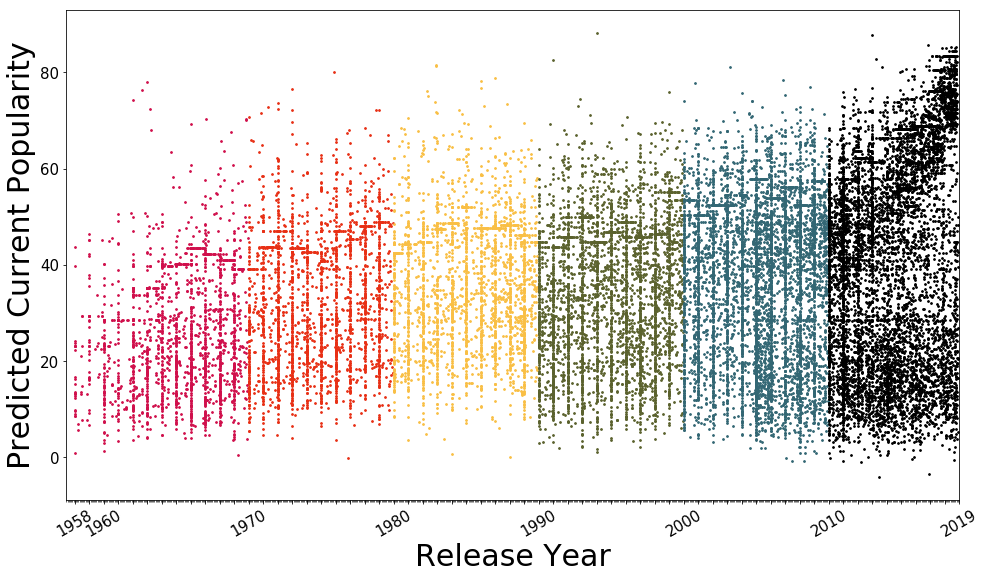

In [409]:
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
from datetime import datetime

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')

# 58-69	#D0104C			#E87A90
# 70-79	#E83015			#F75C2F
# 80-89	#F9BF45			#FFC408
# 90-99	#5B622E			#86C166
# 00-09	#336774			#33A6B8	
# 10-18	#000000			#FFFFFF

scatter_colors = [['#D0104C', '#E87A90'], ['#E83015', '#F75C2F'], ['#F9BF45', '#FFC408'],
                   ['#5B622E', '#86C166'], ['#336774', '#33A6B8'], ['#000000','#666666']]

# plot the predicted and truth popularity of a song.
# X is release year, Y is the popularity, color pairs (bright, dark) means the (predicted, truth) popularity pair

decades = [(1958, 1969), (1970, 1979), (1980, 1989), (1990, 1999), (2000, 2009), (2010, 2018)]

fig, ax = plt.subplots(figsize=(16,10))
# r = analysis_df.iloc[0]
# print (int(r['release_date'].split('-')[0]) >= l)
for i, (ll, rl) in enumerate(decades):
#     print (type(l), type(r))
#     print (i)
    idx = analysis_df.apply(lambda r: (pd.to_numeric((r['release_date'].split('-')[0]))>=ll) & (pd.to_numeric((r['release_date'].split('-')[0]))<=rl ), axis=1)
#     print(idx)
    song_decades = analysis_df[idx]
    dates = [datetime.strptime(d, '%Y-%m-%d').date() for d in song_decades['release_date']]
    ax.scatter(dates, song_decades['predicted_popularity'], c=scatter_colors[i][0], s=3)
#     ax.scatter(song_decades['release_date'], song_decades['spotify_popularity_2018'], c=scatter_colors[i][1], s=0.3)


# format the ticks
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_major_locator(years)
ax.xaxis.set_minor_locator(months)
ax.tick_params(labelsize=15)
datemin = np.datetime64('1957-06-01')
datemax = np.datetime64('2019-01-01')
ax.set_xlim(datemin, datemax)
ax.set_xlabel('Release Year', size=30)
xtl = ['']
for i in range(1958, 2020):
    if i==1958 or i%10==0 or i==2019:
        xtl.append(str(i))
    else:
        xtl.append('')
ax.set_xticklabels(xtl)
ax.set_ylabel('Predicted Current Popularity', size=30)

fig.autofmt_xdate(ha="center")

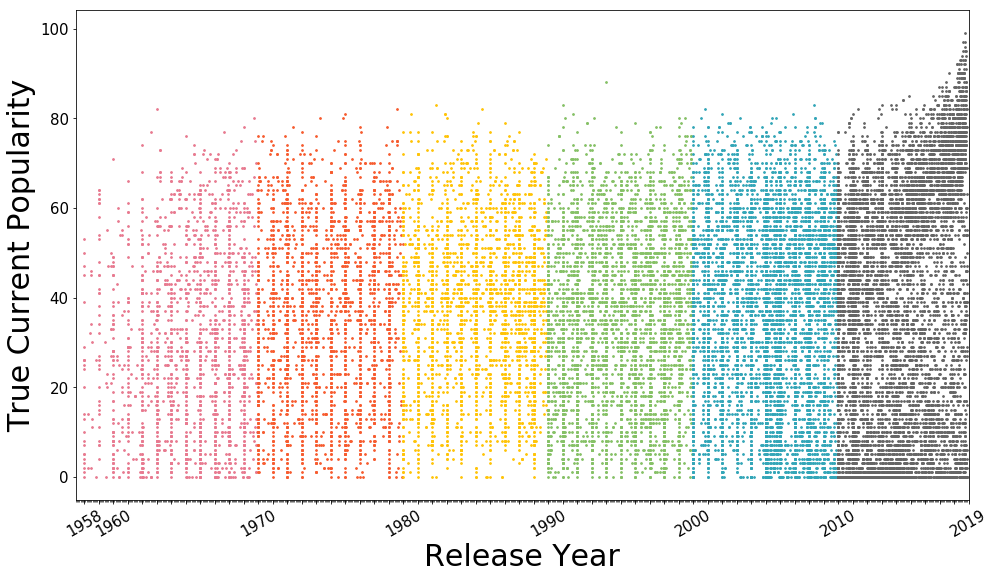

In [410]:
# plot the predicted and truth rank of a song
# X is release year. Y is the rank, color pairs (bright, dark) means the (predicted, truth) rank pair
fig, ax = plt.subplots(figsize=(16,10))
# r = analysis_df.iloc[0]
# print (int(r['release_date'].split('-')[0]) >= l)
for i, (ll, rl) in enumerate(decades):
#     print (type(l), type(r))
#     print (i)
    idx = analysis_df.apply(lambda r: (pd.to_numeric((r['release_date'].split('-')[0]))>=ll) & (pd.to_numeric((r['release_date'].split('-')[0]))<=rl ), axis=1)
#     print(idx)
    song_decades = analysis_df[idx]
    dates = [datetime.strptime(d, '%Y-%m-%d').date() for d in song_decades['release_date']]
#     ax.scatter(song_decades['release_date'], song_decades['predicted_popularity'], c=scatter_colors[i][0], s=0.3)
    ax.scatter(dates, song_decades['spotify_popularity_2018'], c=scatter_colors[i][1], s=3)


# format the ticks
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_major_locator(years)
ax.xaxis.set_minor_locator(months)
ax.tick_params(labelsize=15)
datemin = np.datetime64('1957-06-01')
datemax = np.datetime64('2019-01-01')
ax.set_xlim(datemin, datemax)
ax.set_xlabel('Release Year', size=30)
ax.set_ylabel('True Current Popularity', size=30)
xtl = ['']
for i in range(1958, 2020):
    if i==1958 or i%10==0 or i==2019:
        xtl.append(str(i))
    else:
        xtl.append('')
ax.set_xticklabels(xtl)
fig.autofmt_xdate(ha="center")

In [411]:
feature_gap_df = pd.read_csv(join_path(data_path, 'features_gcorrected.csv'))
FEATURES = ['y_'+str(i) for i in range(0, 61)]


In [437]:
try:
    import cPickle as pickle
except ImportError:  # python 3.x
    import pickle


def feature_shift_year(f):
    t = []
    nf = {}
#     print (f)
    for i in range(0, 61):
        t.append(f['y_'+str(i)])
    for i in range(0, 60):
        nf['y_'+str(i)] = t[i+1]
    nf['y_60'] = 52 # empty score
    nf = pd.Series(nf)
#     print (nf)
    return nf
    
def pred_single_song_middle_years(md, rdict, r, modeltype=''):
    release_date = r['release_date']
    year = int(release_date.split('-')[0])
    cfeatures = r[FEATURES]
    title = r['title']
    name = r['artist_name']
    if title not in rdict:
        rdict[title] = {}
    if name not in rdict[title]:
        rdict[title][name] = []
    for i in range(2018-year):
        new_features = feature_shift_year(cfeatures)
        if modeltype == 'LGBM':
            new_pred = md.predict(new_features, num_iteration=model.best_iteration)
        else:
            new_pred = md.predict(new_features)
        rdict[title][name].append(new_pred[0])
        cfeatures = new_features
        
def pred_middle_years(md, df, modelname=''):
    mid_pred_d = {}
    for i in range(len(df)):
        pred_single_song_middle_years(md, mid_pred_d, df.iloc[i])
        if i % 1000 == 0:
            print (i)
    with open(join_path(data_path, modelname+'_pred_middle_popularity.p'), 'wb') as fp:
        pickle.dump(mid_pred_d, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [438]:
import warnings
warnings.filterwarnings("ignore")
pred_middle_years(lgbm_gap_model, feature_gap_df, 'LGBM_gap')
# type(feature_gap_df.iloc[1])

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000


In [496]:
mid_pred_d = pickle.load(open(join_path(data_path, 'LGBM_gap_pred_middle_popularity.p'), 'rb'))
# mid[title][name] [2017, 2016.... releaseyear]
print (type(mid_pred_d))

<class 'dict'>


In [497]:
analysis_df['spotify_popularity_2018'].describe()

count    25281.000000
mean        35.874451
std         21.783905
min          0.000000
25%         18.000000
50%         36.000000
75%         53.000000
max         99.000000
Name: spotify_popularity_2018, dtype: float64

In [498]:
# mean = 35.87
# std = 21.78
cold_thres = 35.87

In [499]:
analysis_df['predicted_popularity'].describe()

count    25281.000000
mean        35.874451
std         17.516900
min         -4.051063
25%         21.145227
50%         35.315526
75%         48.085741
max         88.153654
Name: predicted_popularity, dtype: float64

In [502]:
def get_not_cold_years(mid_pred_d, resd, r):
    t = r['title']
    n = r['artist_name']
    if t not in resd:
        resd[t] = {}
    if n not in resd[t]:
        resd[t][n] = []
    release_year = int(r['release_date'].split('-')[0])
    if r['spotify_popularity_2018'] > cold_thres:
        resd[t][n].append(2018)
    resd[t][n].extend([2018-i-1 for i in range(2018-release_year) if mid_pred_d[t][n][i] > cold_thres])
    
def analysis_not_cold_years(mid_d, df):
    not_cold_years_d = {}
    for i in range(len(df)):
        get_not_cold_years(mid_d, not_cold_years_d, df.iloc[i])
        if i % 5000 == 0:
            print (i)
    with open(join_path(data_path, 'not_cold_years_mean.p'), 'wb') as fp:
        pickle.dump(not_cold_years_d, fp, protocol=pickle.HIGHEST_PROTOCOL)
    
            

In [500]:
analysis_not_cold_years(mid_pred_d, feature_gap_df)

0
5000
10000
15000
20000
25000


In [503]:
not_cold_d = pickle.load(open(join_path(data_path, 'not_cold_years_mean.p'), 'rb'))
# mid[title][name] [2017, 2016.... releaseyear]
print (type(not_cold_d))

<class 'dict'>


In [504]:
max_year_song = (None, None, -1)
for t in not_cold_d:
    for n in not_cold_d[t]:
        l = len(not_cold_d[t][n])
        if l > max_year_song[2]:
            max_year_song = (t, n, l)
print (max_year_song)

("(now and then there's) a fool such as i", 'elvis presley with the jordanaires', 56)


In [558]:
alive_song_years = create_new_empty_data_dict(['title', 'name', 'release_date', 
                                              'years', 'alive_lifespan_ratio', 'maximum_possible_alive',
                                              'spotify_popularity_2018'])
for i in range(len(feature_gap_df)):
    r = feature_gap_df.iloc[i]
    t = r['title']
    n = r['artist_name']
    release_year = int(r['release_date'].split('-')[0])
    alive_song_years['title'].append(t)
    alive_song_years['name'].append(n)
    alive_song_years['release_date'].append(r['release_date'])
    alive_song_years['years'].append(len(not_cold_d[t][n]))
    alive_song_years['alive_lifespan_ratio'].append(len(not_cold_d[t][n])/(2018-release_year+1))
    alive_song_years['maximum_possible_alive'].append(2018-release_year+1)
    alive_song_years['spotify_popularity_2018'].append(r['spotify_popularity_2018'])
alive_song_years = pd.DataFrame.from_dict(alive_song_years)
alive_song_years = alive_song_years.sort_values('years', ascending=False)
alive_song_years.to_csv(join_path(data_path, 'alive_song_years_mean.csv'))
alive_song_years

,title,name,release_date,years,alive_lifespan_ratio,maximum_possible_alive,spotify_popularity_2018
22584,twistin' the night away,sam cooke,1962-04-1,56,0.982456,57,58
17411,roses are red (my love),bobby vinton,1962-1-1,56,0.982456,57,52
2500,blue velvet,bobby vinton,1962-1-1,56,0.982456,57,62
18793,so much in love,the tymes,1963-01-01,56,1.000000,56,38
115,(now and then there's) a fool such as i,elvis presley with the jordanaires,1959-11-13,56,0.933333,60,47
16423,pony time,chubby checker,1961-01-01,56,0.965517,58,59
21201,the one who really loves you,mary wells,1962-1-1,56,0.982456,57,49
11196,it's my party,lesley gore,1963-06-01,56,1.000000,56,52
9894,i will follow him,little peggy march,1963-1-1,56,1.000000,56,46
19895,surfer girl,the beach boys,1963-09-16,56,1.000000,56,48


In [470]:
lgbm_gap_model.save_model(join_path(data_path, 'lgbm_gap_model_paras.txt'))

In [509]:
len(alive_song_years[alive_song_years['alive_lifespan_ratio'] == 1.0])
#we have 5415 songs among 25281 samples which are keeping its popularity above the average all the way before they released based on our prediction.

5415

(array([2853.,   86.,  244.,  303.,  242.,  271.,  239.,  278.,  219.,
         115.,  277.,  158.,  258.,  196.,  231.,  218.,  368.,  268.,
         296.,  242.,  356.,  329.,  313.,  305.,  210.,  650.,  277.,
         298.,  328.,  238.,  420.,  293.,  324.,  441.,  337.,  298.,
         312.,  480.,  356.,  229.,  645.,  487.,  605.,  520.,  515.,
         808.,  777.,  697.,  600., 5471.]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ]),
 <a list of 50 Patch objects>)

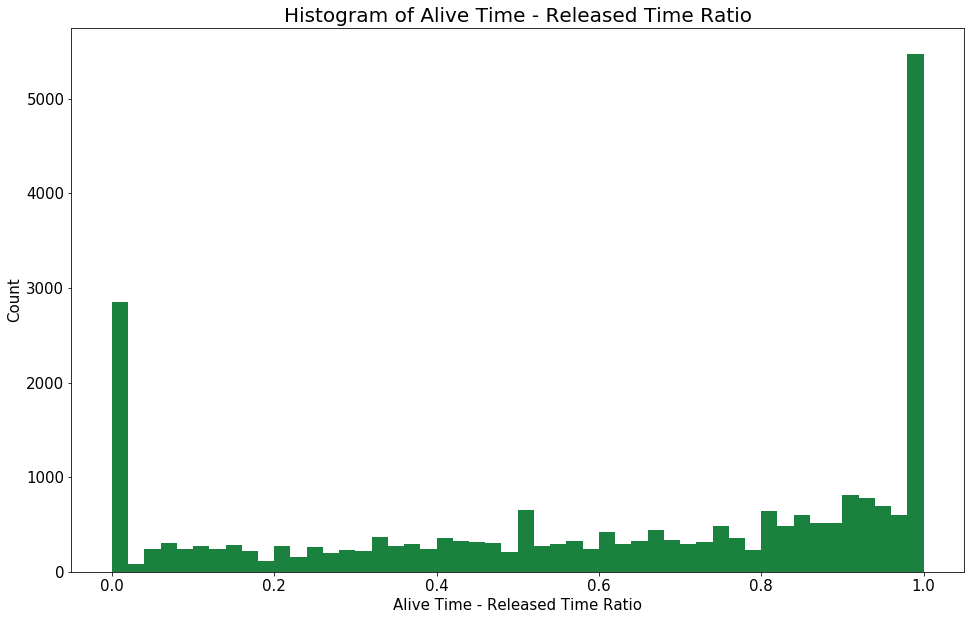

In [520]:
fig, ax = plt.subplots(figsize=(16,10))

ax.tick_params(labelsize=15)
ax.set_title('Histogram of Alive Time - Released Time Ratio', fontsize=20)
ax.set_xlabel('Alive Time - Released Time Ratio', fontsize=15)
ax.set_ylabel('Count', fontsize=15)

ax.hist(alive_song_years['alive_lifespan_ratio'], bins=50, color="#1B813E")

(array([2852., 2016., 1372., 1002.,  917.,  810.,  734.,  732.,  804.,
         707.,  658.,  567.,  529.,  561.,  606.,  627.,  678.,  802.,
         812.,  708.,  670.,  589.,  505.,  475.,  442.,  427.,  392.,
         367.,  298.,  293.,  222.,  219.,  175.,  148.,  145.,  106.,
         126.,   97.,   94.,   90.,   91.,   91.,   80.,   70.,   69.,
          72.,   67.,   54.,   44.,   33.,   37.,   35.,   29.,   27.,
          29.,   79.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
        39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
        52., 53., 54., 55., 56.]),
 <a list of 56 Patch objects>)

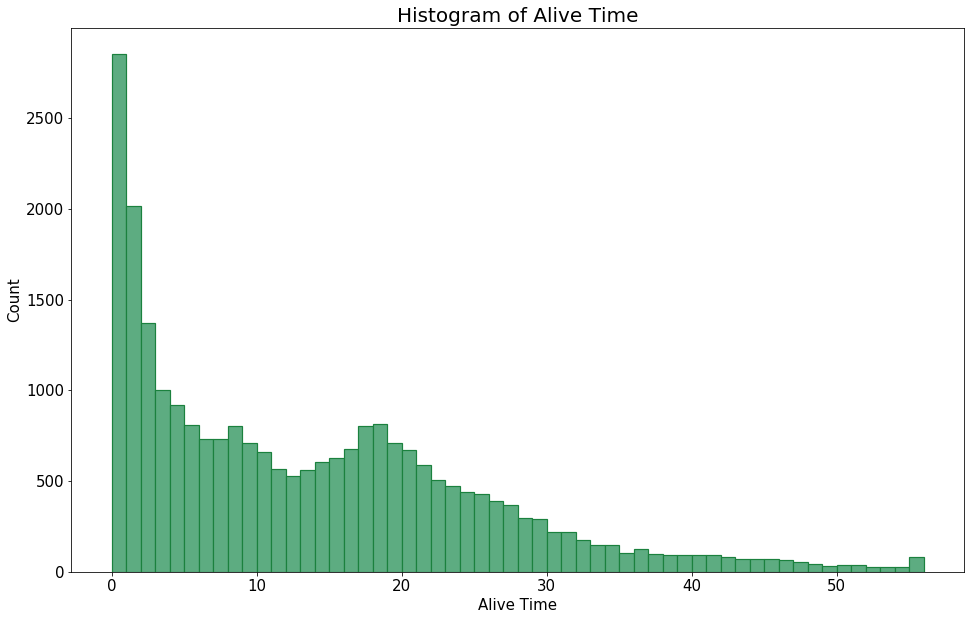

In [522]:
fig, ax = plt.subplots(figsize=(16,10))

ax.tick_params(labelsize=15)
ax.set_title('Histogram of Alive Time', fontsize=20)
ax.set_xlabel('Alive Time', fontsize=15)
ax.set_ylabel('Count', fontsize=15)

ax.hist(alive_song_years['years'], bins=56, color="#5DAC81", edgecolor='#1B813E', linewidth=1.2)

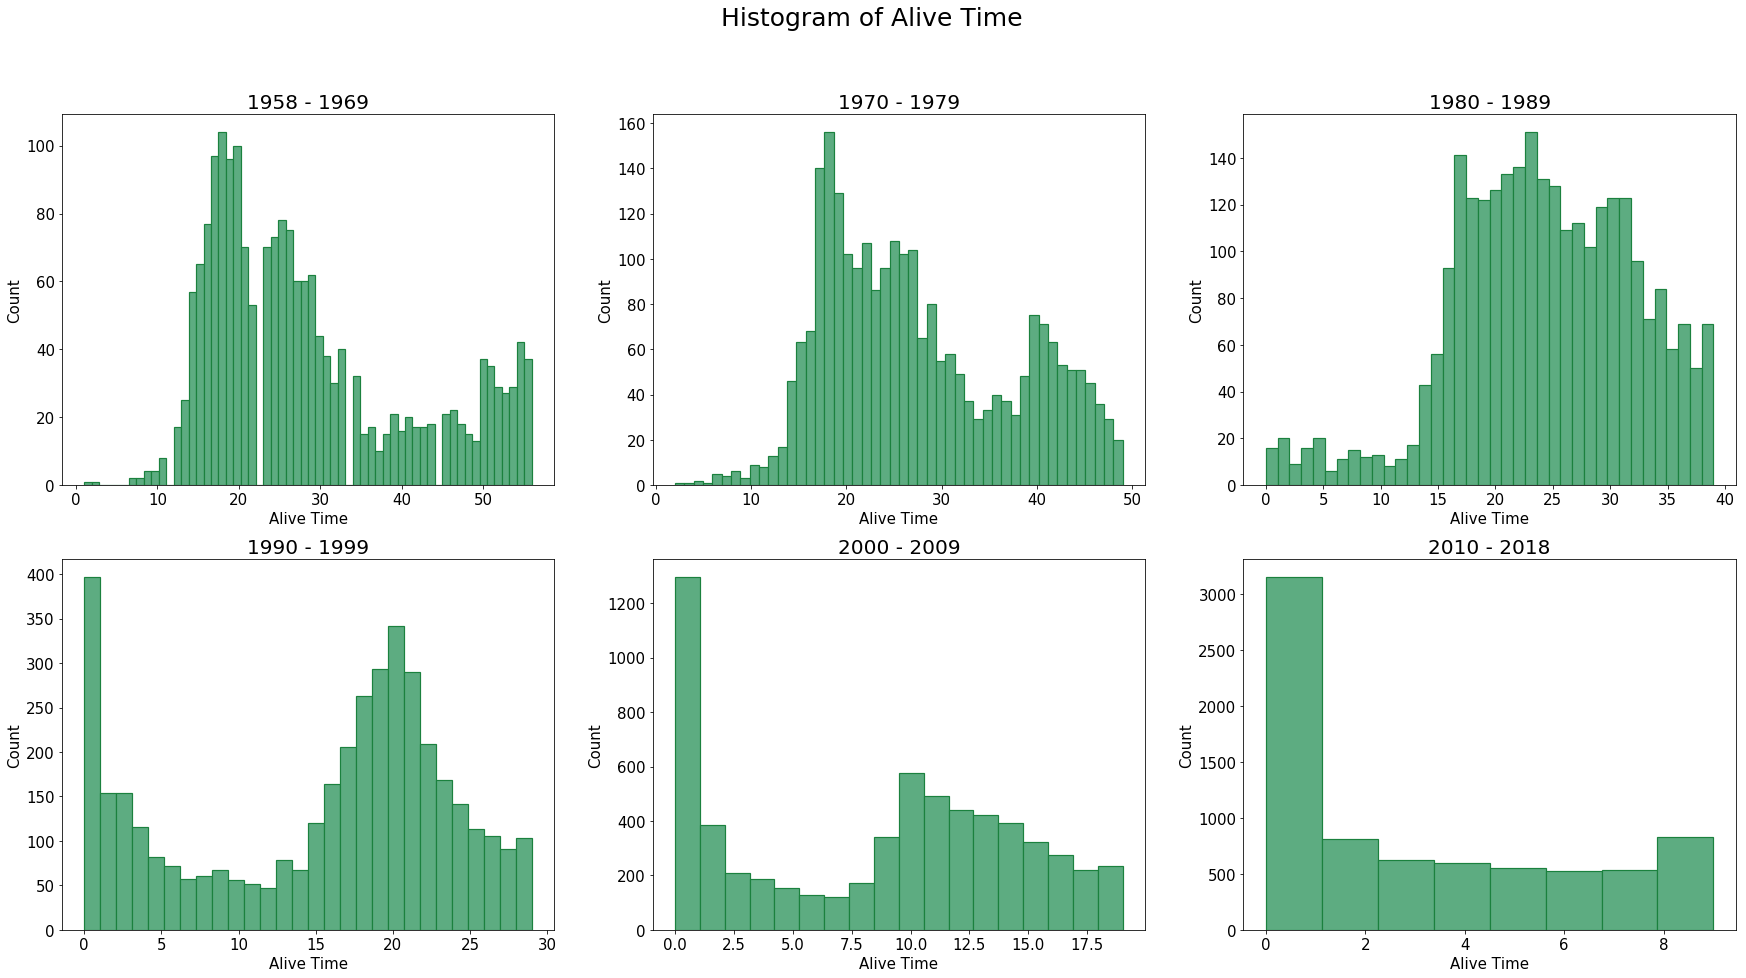

In [531]:
decades = [(1958, 1969), (1970, 1979), (1980, 1989), (1990, 1999), (2000, 2009), (2010, 2018)]

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(30,15))

fig.suptitle('Histogram of Alive Time', fontsize=25)
for i, (ll, rl) in enumerate(decades):
    ax = axes[i//3][i%3]
    ax.tick_params(labelsize=15)
    ax.set_title('{} - {}'.format(ll, rl), fontsize=20)
    ax.set_xlabel('Alive Time (years)', fontsize=15)
    ax.set_ylabel('Counts', fontsize=15)

    idx = alive_song_years.apply(lambda r: (int((r['release_date'].split('-')[0]))>=ll) & (int((r['release_date'].split('-')[0]))<=rl ), axis=1)
    song_decades = alive_song_years[idx]
    
    ax.hist(song_decades['years'], bins=2018-ll, color="#5DAC81", edgecolor='#1B813E', linewidth=1.2)

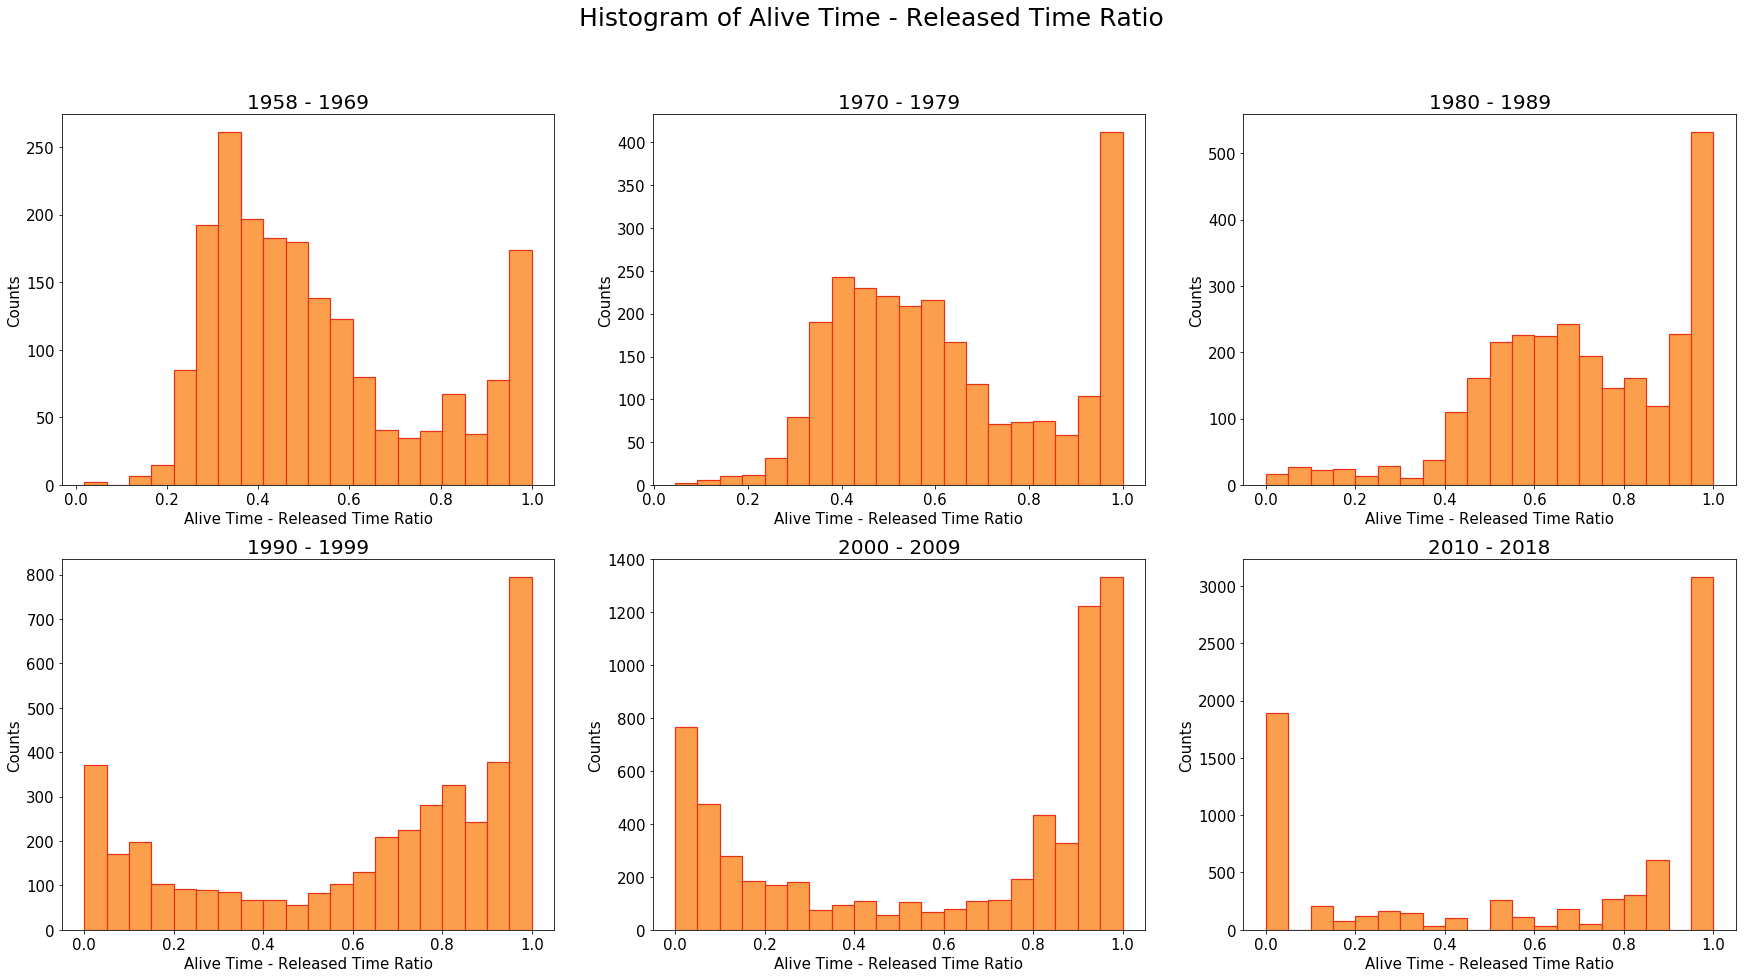

In [537]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(30,15))
fig.suptitle('Histogram of Alive Time - Released Time Ratio', fontsize=25)
for i, (ll, rl) in enumerate(decades):
    ax = axes[i//3][i%3]
    ax.tick_params(labelsize=15)
    ax.set_title('{} - {}'.format(ll, rl), fontsize=20)
    ax.set_xlabel('Alive Time - Released Time Ratio', fontsize=15)
    ax.set_ylabel('Counts', fontsize=15)
    
    idx = alive_song_years.apply(lambda r: (int((r['release_date'].split('-')[0]))>=ll) & (int((r['release_date'].split('-')[0]))<=rl ), axis=1)
    song_decades = alive_song_years[idx]
    
    ax.hist(song_decades['alive_lifespan_ratio'], bins=20, color="#FC9F4D", edgecolor='#E83015', linewidth=1.2)

------Top 10 From 1958 - 1969: 
stand by me 		 ben e. king 		 ['adult standards', 'brill building pop', 'christmas', 'motown', 'quiet storm', 'rock-and-roll', 'rockabilly', 'soul', 'southern soul']
57
blue velvet 		 bobby vinton 		 ['adult standards', 'brill building pop', 'bubblegum pop', 'christmas', 'doo-wop', 'easy listening', 'folk rock', 'lounge', 'mellow gold', 'rock-and-roll', 'rockabilly']
57
what a diff'rence a day makes 		 dinah washington 		 ['adult standards', 'cabaret', 'christmas', 'jazz blues', 'lounge', 'soul', 'swing', 'vocal jazz']
60
runaround sue 		 dion 		 ['canadian pop', 'dance pop']
58
heat wave 		 martha & the vandellas 		 ['brill building pop', 'christmas', 'classic girl group', 'classic soul', 'disco', 'funk', 'motown', 'quiet storm', 'rock-and-roll', 'soul', 'southern soul']
56
pony time 		 chubby checker 		 ['adult standards', 'brill building pop', 'bubblegum pop', 'christmas', 'doo-wop', 'rock-and-roll', 'rockabilly']
58
twistin' the night away 		 sam coo

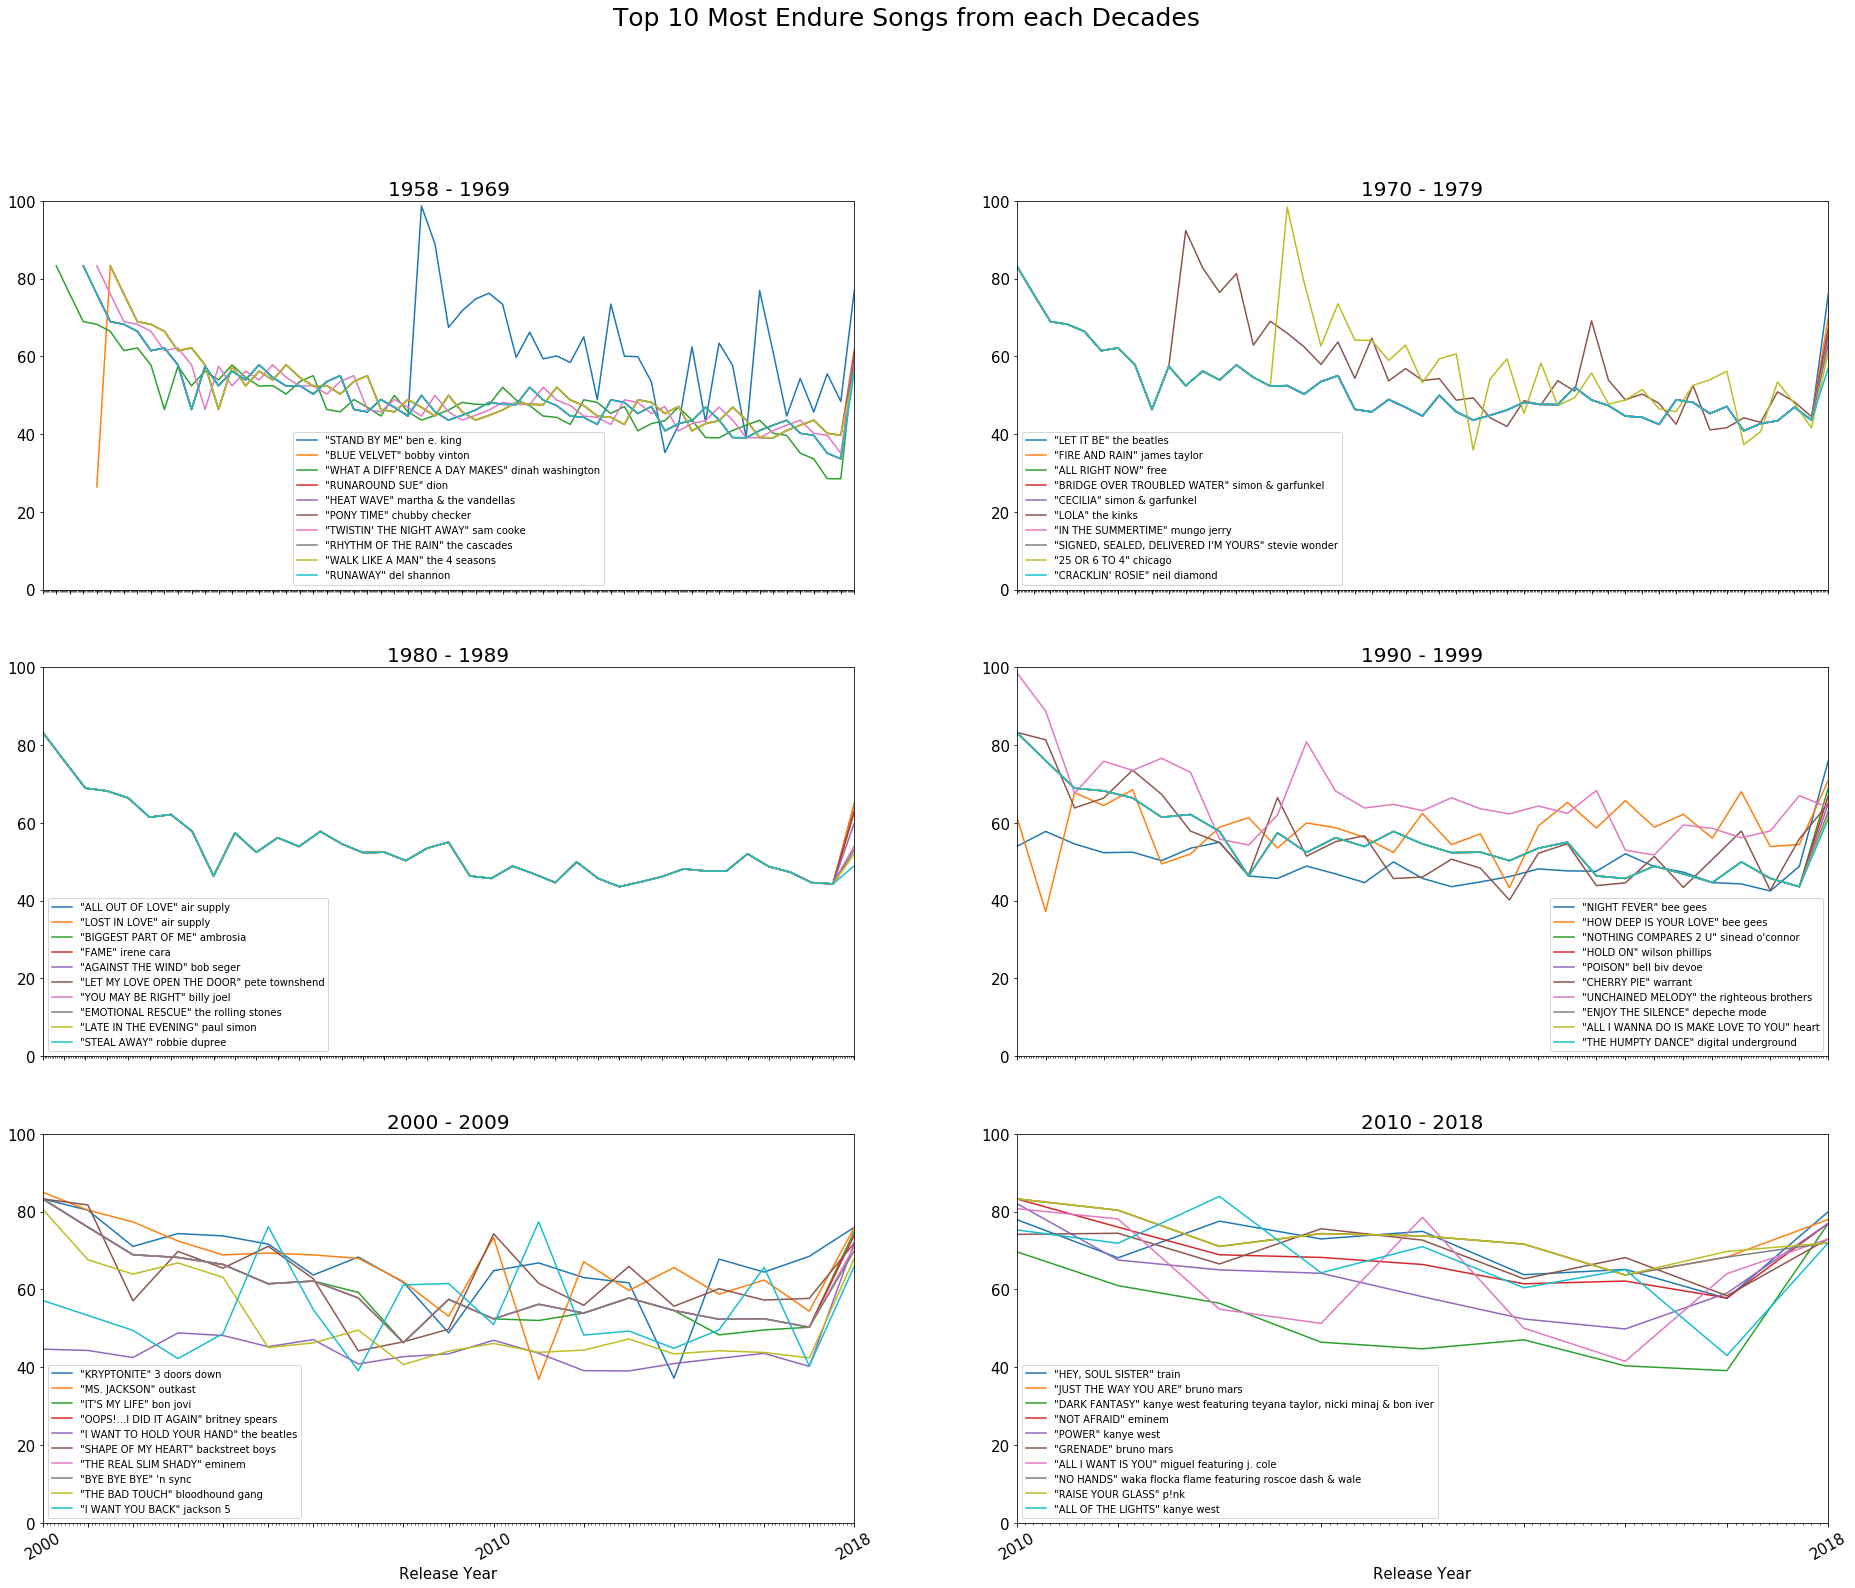

In [607]:
decades_genres = []
decades_top_names = []
decades_top_titles = []

decades = [(1958, 1969), (1970, 1979), (1980, 1989), (1990, 1999), (2000, 2009), (2010, 2018)]
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(32,27))
fig.suptitle('Top 10 Most Endure Songs from each Decades', fontsize=25)
for i, (ll, rl) in enumerate(decades):
    ax = axes[i//2][i%2]
    ax.set_title('{} - {}'.format(ll, rl), fontsize=20)
    legends = []
    
    
    idx = alive_song_years.apply(lambda r: (int((r['release_date'].split('-')[0]))>=ll) & (int((r['release_date'].split('-')[0]))<=rl ), axis=1)
    song_decades = alive_song_years[idx].sort_values(['years', 'spotify_popularity_2018'], ascending=False)
    top10songs = song_decades[:10]
#     print (len(top10songs))
    
    print ('------Top 10 From {} - {}: '.format(ll, rl))
    gs = []
    dtn = []
    dtt = []
    for j in range(len(top10songs)):
        song = top10songs.iloc[j]
        t = song['title']
        n = song['name']
        
        print (t, '\t\t', n, '\t\t', genre_dict[n])
        gs.append(genre_dict[n])
        dtn.append(n)
        dtt.append(t)
        release_year = int(song['release_date'].split('-')[0])
        p_popu = mid_pred_d[t][n][::-1]+[song['spotify_popularity_2018']]
        print (len(p_popu))
        ys = [datetime.strptime(str(k)+'-01-01', '%Y-%m-%d').date() for k in range(release_year, 2019)]
        ax.plot(ys, p_popu)
        legends.append('"'+t.upper()+'" '+n)
    decades_genres.append(gs)
    decades_top_names.append(dtn)
    decades_top_titles.append(dtt)
    ax.legend(legends)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_minor_locator(mdates.MonthLocator())
    ax.tick_params(labelsize=15)
    datemin = np.datetime64('{}-01-01'.format(ll))
    datemax = np.datetime64('2018-01-01')
    ax.set_xlim(datemin, datemax)
    ax.set_ylim(0, 100)
    xtl = []
    for k in range(ll, 2019):
#         print (k)
        if k==ll or k%10==0 or k==2018:
            xtl.append(str(k))
        else:
            xtl.append('')
#     print (xtl)
    ax.set_xticklabels(xtl)
    ax.set_xlabel('Release Year', size=15)
fig.autofmt_xdate(ha="center")

In [538]:
genre_dict = pickle.load(open(join_path(data_path, 'artist_genre.p'), 'rb'))

In [608]:
decades_genres = []
decades_top_names = []
decades_top_titles = []

decades = [(1958, 1969), (1970, 1979), (1980, 1989), (1990, 1999), (2000, 2009), (2010, 2018)]
for i, (ll, rl) in enumerate(decades):
    ax = axes[i//2][i%2]
    ax.set_title('{} - {}'.format(ll, rl), fontsize=20)
    legends = []
    
    
    idx = alive_song_years.apply(lambda r: (int((r['release_date'].split('-')[0]))>=ll) & (int((r['release_date'].split('-')[0]))<=rl ), axis=1)
    song_decades = alive_song_years[idx].sort_values(['years', 'spotify_popularity_2018'], ascending=False)
    if len(song_decades) < 100:
        top10songs = song_decades[:len(song_decades)//2]
    else:
        top10songs = song_decades[:100]

    gs = []
    dtn = []
    dtt = []
    for j in range(len(top10songs)):
        song = top10songs.iloc[j]
        t = song['title']
        n = song['name']
        
        gs.append(genre_dict[n])
        dtn.append(n)
        dtt.append(t)
    decades_genres.append(gs)
    decades_top_names.append(dtn)
    decades_top_titles.append(dtt)


In [610]:
flatterned_genres = []
for i, g in enumerate(decades_genres):
    flatterned_genres.append([])
    for j in range(len(g)):
        if g[j] and len(g[j]) > 0:
            flatterned_genres[i].extend(g[j])
flatterned_genres

[['adult standards',
  'brill building pop',
  'christmas',
  'motown',
  'quiet storm',
  'rock-and-roll',
  'rockabilly',
  'soul',
  'southern soul',
  'adult standards',
  'brill building pop',
  'bubblegum pop',
  'christmas',
  'doo-wop',
  'easy listening',
  'folk rock',
  'lounge',
  'mellow gold',
  'rock-and-roll',
  'rockabilly',
  'adult standards',
  'cabaret',
  'christmas',
  'jazz blues',
  'lounge',
  'soul',
  'swing',
  'vocal jazz',
  'canadian pop',
  'dance pop',
  'brill building pop',
  'christmas',
  'classic girl group',
  'classic soul',
  'disco',
  'funk',
  'motown',
  'quiet storm',
  'rock-and-roll',
  'soul',
  'southern soul',
  'adult standards',
  'brill building pop',
  'bubblegum pop',
  'christmas',
  'doo-wop',
  'rock-and-roll',
  'rockabilly',
  'adult standards',
  'brill building pop',
  'christmas',
  'classic soul',
  'rock-and-roll',
  'soul',
  'southern soul',
  'adult standards',
  'brill building pop',
  'christmas',
  'doo-wop',
  'r

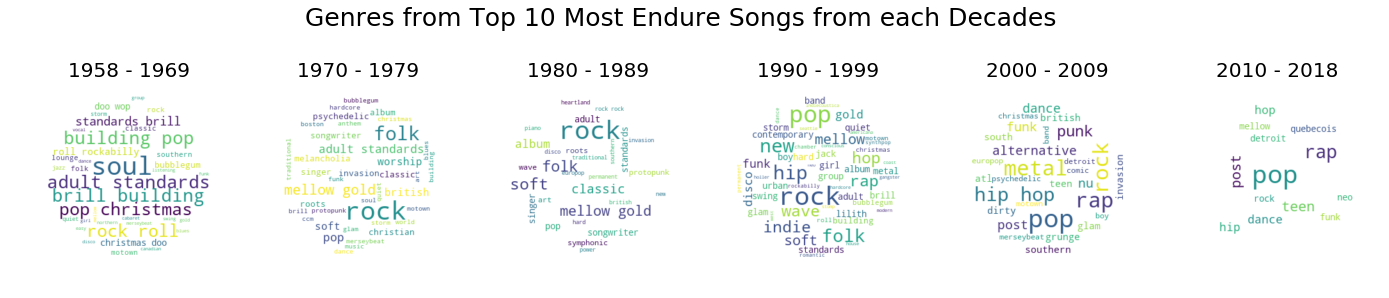

In [606]:
from wordcloud import WordCloud
decades = [(1958, 1969), (1970, 1979), (1980, 1989), (1990, 1999), (2000, 2009), (2010, 2018)]
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(24,5))
fig.suptitle('Genres from Top 10 Most Endure Songs from each Decades', fontsize=25)
for i, (ll, rl) in enumerate(decades):
    ax = axes[i%6]
    ax.set_title('{} - {}'.format(ll, rl), fontsize=20)
    
    gs = ' '.join(flatterned_genres[i])
    
#     wordcloud = WordCloud().generate(text)
    x, y = np.ogrid[:300, :300]

    mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
    mask = 255 * mask.astype(int)
    wordcloud = WordCloud(background_color="white", max_font_size=40, mask=mask).generate(gs)
    ax.axis('off')
    ax.imshow(wordcloud, interpolation="bilinear")


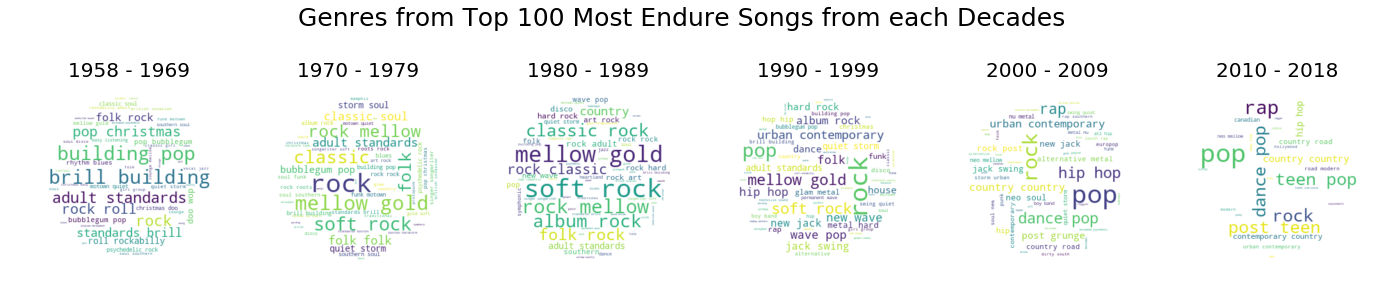

In [611]:
from wordcloud import WordCloud
decades = [(1958, 1969), (1970, 1979), (1980, 1989), (1990, 1999), (2000, 2009), (2010, 2018)]
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(24,5))
fig.suptitle('Genres from Top 100 Most Endure Songs from each Decades', fontsize=25)
for i, (ll, rl) in enumerate(decades):
    ax = axes[i%6]
    ax.set_title('{} - {}'.format(ll, rl), fontsize=20)
    
    gs = ' '.join(flatterned_genres[i])
    
#     wordcloud = WordCloud().generate(text)
    x, y = np.ogrid[:300, :300]

    mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
    mask = 255 * mask.astype(int)
    wordcloud = WordCloud(background_color="white", max_font_size=40, mask=mask).generate(gs)
    ax.axis('off')
    ax.imshow(wordcloud, interpolation="bilinear")

In [ ]:
top_endure_features:
for i, (ll, rl) in enumerate(decades):
    dtn = decades_top_names[i]
    dtt = decades_top_titles[i]
    for j in range(len(dtn)):
        t = dtt[j]
        n = dtn[j]
        r = feature_gap_df[(feature_gap_df['artist_name']==n) & (feature_gap_df['title']==t)]
        bill_peak = r['peak_rank']
        weak_o_c = r['weeks_on_chart']
        wgrammy = r['grammy']
        wama = r['ama']